# Part 2, XGBoost

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.cross_validation import KFold, train_test_split
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


这部分主要内容就是Xgboost啦

## 数据预处理

In [2]:
train = pd.read_csv('train.csv')

做对数转换

In [3]:
train['log_loss'] = np.log(train['loss'])

数据分成连续和离散特征

In [4]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 116
Numerical features: 14


And use a label encoder for categorical features:

In [5]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


## Simple XGBoost Model

首先，我们训练一个基本的xgboost模型，然后进行参数调节通过交叉验证来观察结果的变换，使用平均绝对误差来衡量

mean_absolute_error(np.exp(y), np.exp(yhat))。


xgboost 自定义了一个数据矩阵类 DMatrix，会在训练开始时进行一遍预处理，从而提高之后每次迭代的效率

In [6]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

### Model

In [12]:
dtrain = xgb.DMatrix(train_x, train['log_loss'])

## Xgboost参数
- 'booster':'gbtree',
- 'objective': 'multi:softmax', 多分类的问题
- 'num_class':10, 类别数，与 multisoftmax 并用
- 'gamma':损失下降多少才进行分裂
- 'max_depth':12, 构建树的深度，越大越容易过拟合
- 'lambda':2,  控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
- 'subsample':0.7, 随机采样训练样本
- 'colsample_bytree':0.7, 生成树时进行的列采样
- 'min_child_weight':3, 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束
- 'silent':0 ,设置成1则没有运行信息输出，最好是设置为0.
- 'eta': 0.007, 如同学习率
- 'seed':1000,
- 'nthread':7, cpu 线程数

In [13]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}

使用交叉验证 `xgb.cv` 

In [15]:
%%time


        

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1218.92834467
Wall time: 1min 6s


我们得到了第一个基准结果：MAE＝1218.9

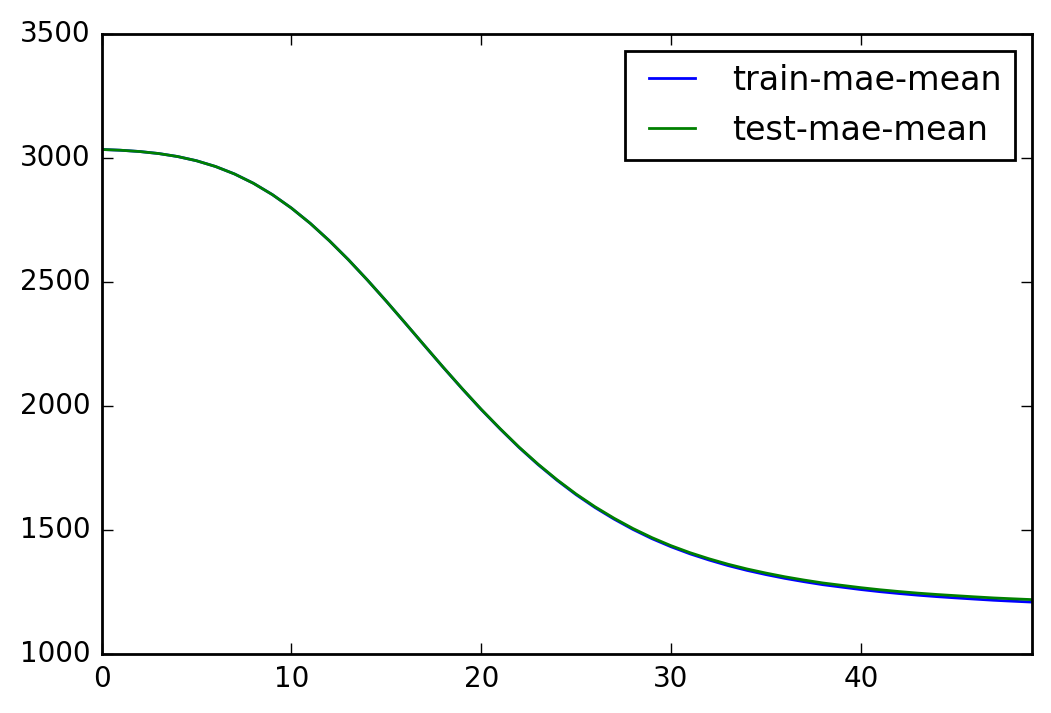

In [16]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

### 我们的第一个基础模型：

* 没有发生过拟合
* 只建立了50个树模型


In [17]:
%%time
#建立100个树模型
bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 1171.13663733
Wall time: 1min 57s


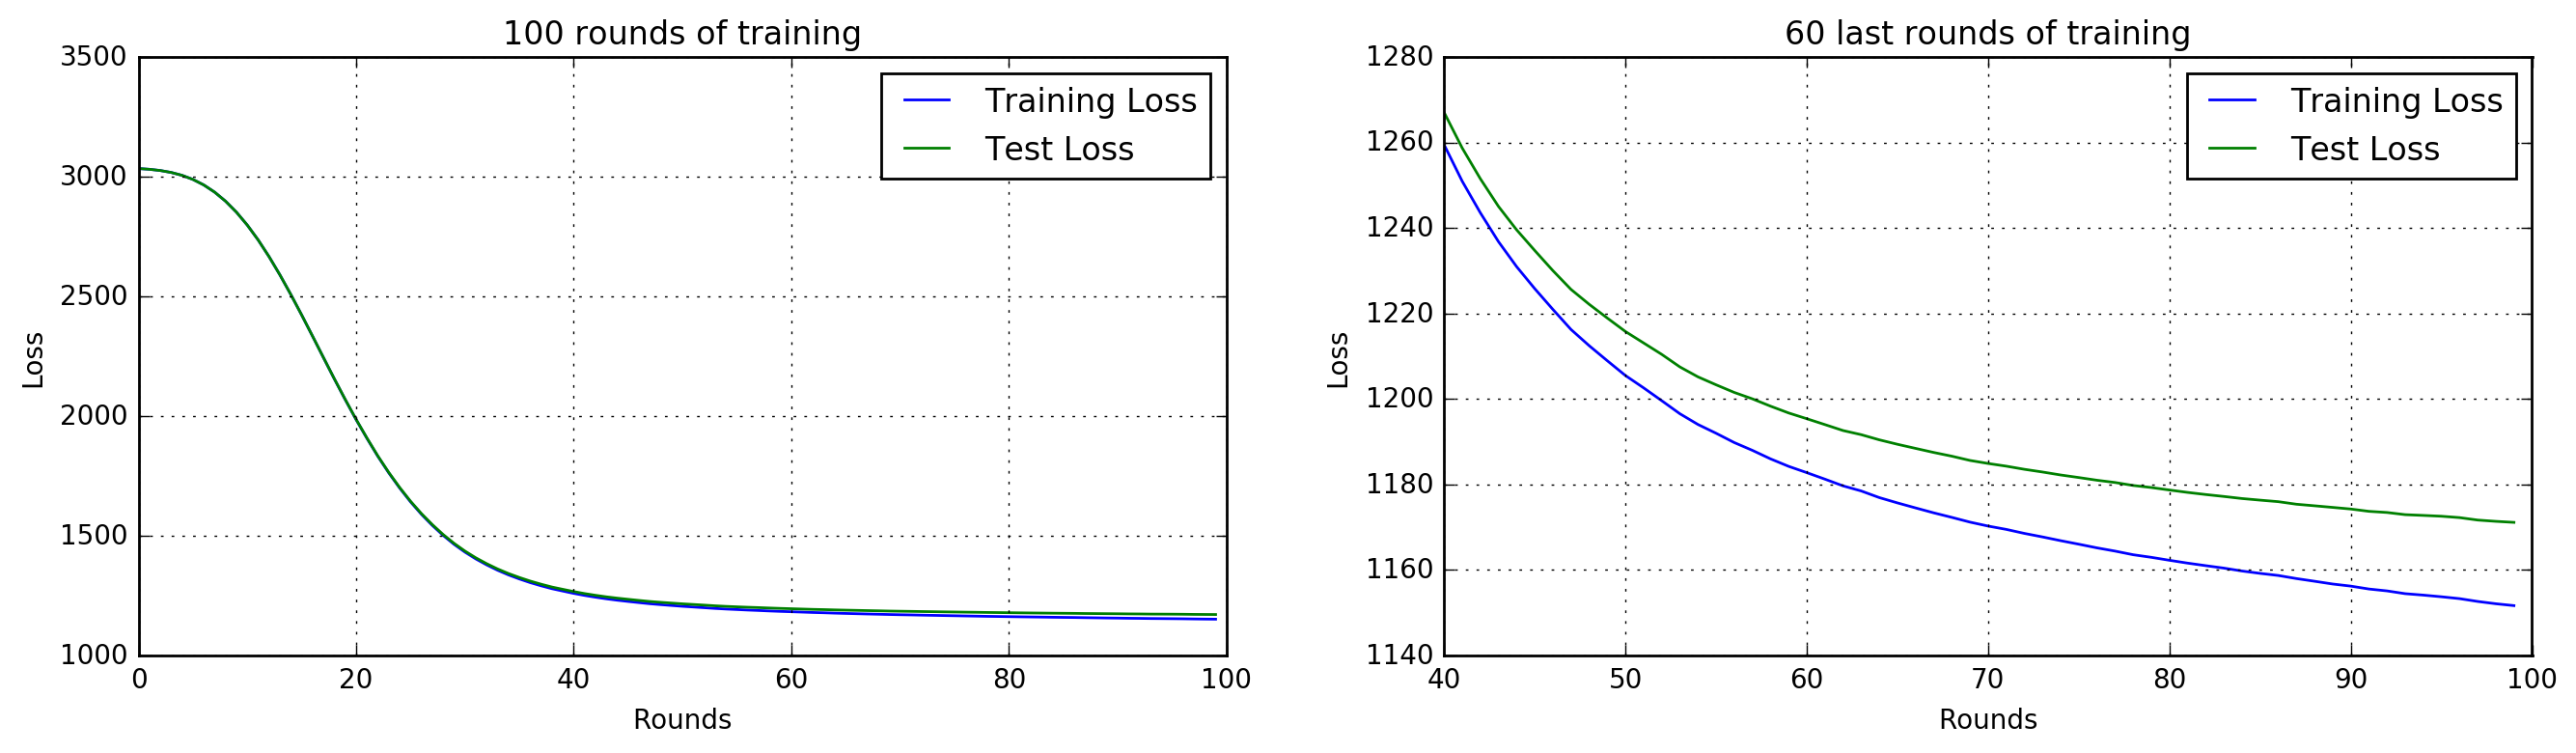

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

有那么一丁丁过拟合，现在还没多大事

我们得到了新的纪录 **MAE = 1171.77** 比第一次的要好 (1218.9). 接下来我们要改变其他参数了。

## XGBoost 参数调节

* Step 1: 选择一组初始参数


* Step 2: 改变 `max_depth` 和 `min_child_weight`.


* Step 3: 调节 `gamma` 降低模型过拟合风险.


* Step 4: 调节 `subsample` 和 `colsample_bytree` 改变数据采样策略.


* Step 5: 调节学习率 `eta`.

In [19]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [20]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [21]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)

In [22]:
bst.kfold(train_x, train_y, nfold=5)

test-mae-mean     1219.014551
test-mae-std         8.931061
train-mae-mean    1210.682813
train-mae-std        2.798608
Name: 49, dtype: float64

### Step 1: 学习率与树个数

### Step 2: 树的深度与节点权重

这些参数对xgboost性能影响最大，因此，他们应该调整第一。我们简要地概述它们：


* `max_depth`: 树的最大深度。增加这个值会使模型更加复杂，也容易出现过拟合，深度3-10是合理的。

* `min_child_weight`: 正则化参数. 如果树分区中的实例权重小于定义的总和，则停止树构建过程。

In [29]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [30]:
%%time
 
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 29min 48s


In [31]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1243.19015, std: 6.70264, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -1243.30647, std: 6.82365, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -1243.50752, std: 6.60994, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -1219.60926, std: 7.09979, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -1218.72940, std: 6.82721, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -1219.25033, std: 6.89855, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -1204.68929, std: 6.28730, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -1203.44649, std: 7.19550, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -1203.76522, std: 7.13140, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -1195.35465, std: 6.38664, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -1194.02729, std: 6.69778, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -1193.51933, std: 6.73645, params: {'max_depth': 7, 'min_child_weigh

网格搜索发现的最佳结果:

`{'max_depth': 8, 'min_child_weight': 6},
 -1187.9597499123447)`
 
设置成负的值是因为要找大的值


In [32]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [36]:
_,scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

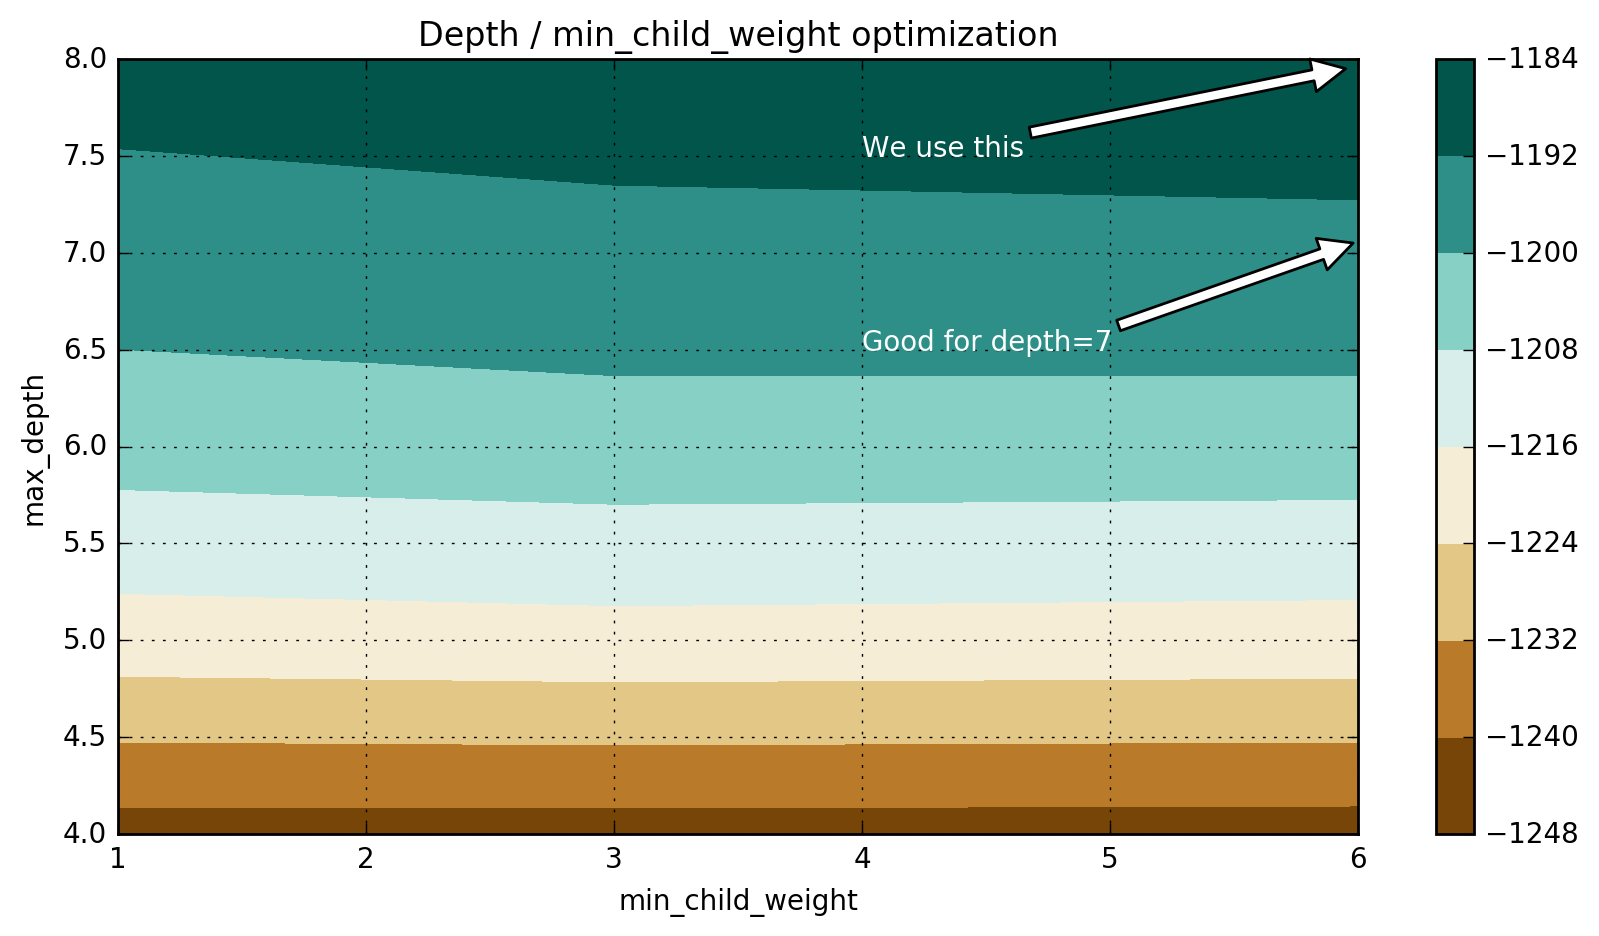

In [37]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

我们看到，从网格搜索的结果，分数的提高主要是基于max_depth增加.
min_child_weight稍有影响的成绩，但是，我们看到，min_child_weight = 6会更好一些。

### Step 3: 调节 gamma去降低过拟合风险

In [38]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

Wall time: 13min 45s


In [39]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1187.95975, std: 6.71340, params: {'gamma': 0.0},
  mean: -1187.67788, std: 6.44332, params: {'gamma': 0.1},
  mean: -1187.66616, std: 6.75004, params: {'gamma': 0.2},
  mean: -1187.21835, std: 7.06771, params: {'gamma': 0.30000000000000004},
  mean: -1188.35004, std: 6.50057, params: {'gamma': 0.4}],
 {'gamma': 0.30000000000000004},
 -1187.2183540791846)

我们选择使用偏小一些的 `gamma`.

### Step 4: 调节样本采样方式 subsample 和 colsample_bytree

In [40]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

Wall time: 28min 26s


In [41]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1185.67108, std: 5.40097, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.6000000000000001},
  mean: -1184.90641, std: 5.61239, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001},
  mean: -1183.73767, std: 6.15639, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.8},
  mean: -1185.09329, std: 7.04215, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.6000000000000001},
  mean: -1184.36149, std: 5.71298, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.7000000000000001},
  mean: -1183.83446, std: 6.24654, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.8},
  mean: -1184.43055, std: 6.68009, params: {'colsample_bytree': 0.8, 'subsample': 0.6000000000000001},
  mean: -1183.33878, std: 5.74989, params: {'colsample_bytree': 0.8, 'subsample': 0.7000000000000001},
  mean: -1182.93099, std: 5.75849, params: {'colsample_bytree': 0.8, 'subsample': 0.8}],
 {'colsample_bytree': 0.8, 

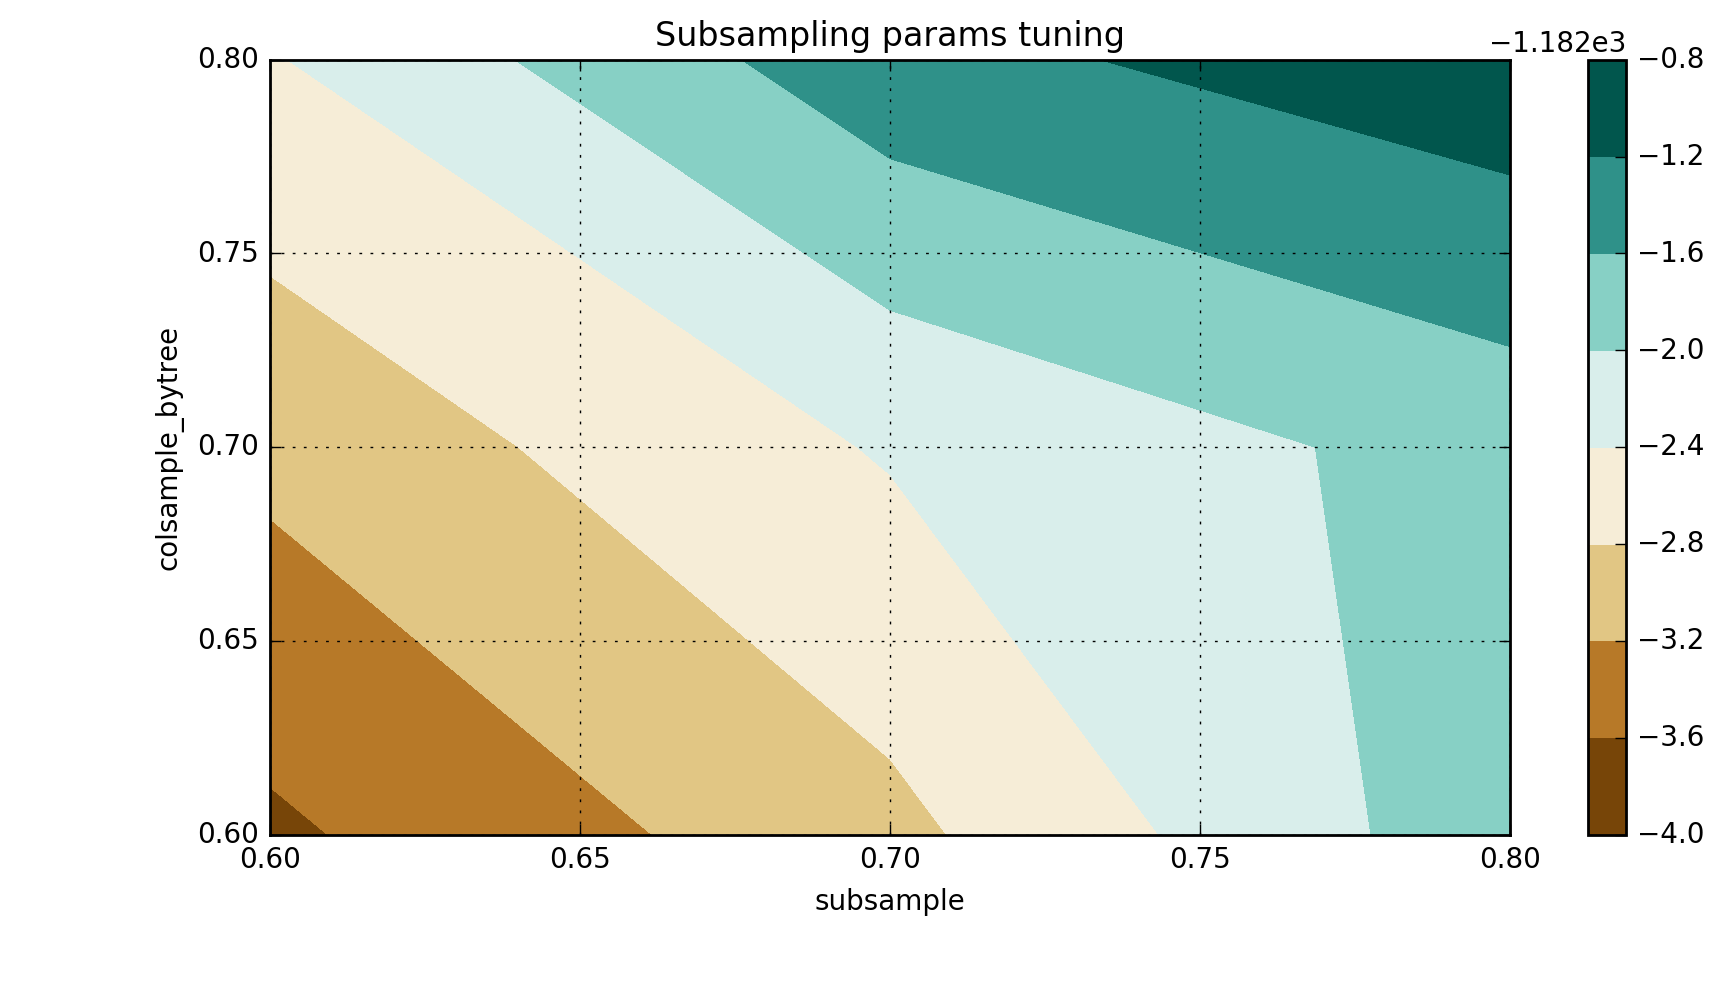

In [44]:
_, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(3,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

在当前的预训练模式的具体案例，我得到了下面的结果：

`{'colsample_bytree': 0.8, 'subsample': 0.8},
 -1182.9309918891634)

### Step 5: 减小学习率并增大树个数

参数优化的最后一步是降低学习速度，同时增加更多的估计量

First, we plot different learning rates for a simpler model (50 trees):

In [29]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: user 6.69 ms, sys: 0 ns, total: 6.69 ms
Wall time: 6.55 ms


In [30]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1205.85372, std: 3.46146, params: {'eta': 0.5},
  mean: -1185.32847, std: 4.87321, params: {'eta': 0.4},
  mean: -1170.00284, std: 4.76399, params: {'eta': 0.3},
  mean: -1160.97363, std: 6.05830, params: {'eta': 0.2},
  mean: -1183.66720, std: 6.69439, params: {'eta': 0.1},
  mean: -1266.12628, std: 7.26130, params: {'eta': 0.075},
  mean: -1709.15130, std: 8.19994, params: {'eta': 0.05},
  mean: -2104.42708, std: 8.02827, params: {'eta': 0.04},
  mean: -2545.97334, std: 7.76440, params: {'eta': 0.03}],
 {'eta': 0.2},
 -1160.9736284869114)

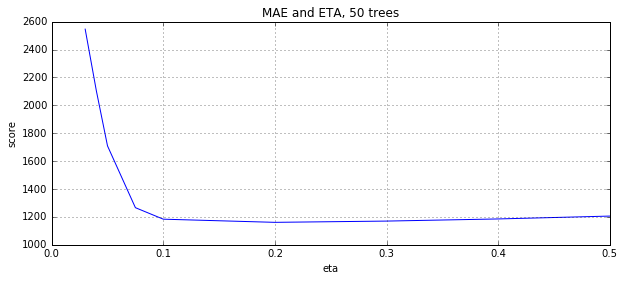

In [31]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

`{'eta': 0.2}, -1160.9736284869114` 是目前最好的结果

现在我们把树的个数增加到100

In [32]:

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 11.4 ms


In [33]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1231.04517, std: 5.41136, params: {'eta': 0.5},
  mean: -1201.31398, std: 4.75456, params: {'eta': 0.4},
  mean: -1177.86344, std: 3.67324, params: {'eta': 0.3},
  mean: -1160.48853, std: 5.65336, params: {'eta': 0.2},
  mean: -1152.24715, std: 5.85286, params: {'eta': 0.1},
  mean: -1156.75829, std: 5.30250, params: {'eta': 0.075},
  mean: -1184.88913, std: 6.08852, params: {'eta': 0.05},
  mean: -1243.60808, std: 7.40326, params: {'eta': 0.04},
  mean: -1467.04736, std: 8.70704, params: {'eta': 0.03}],
 {'eta': 0.1},
 -1152.2471498726127)

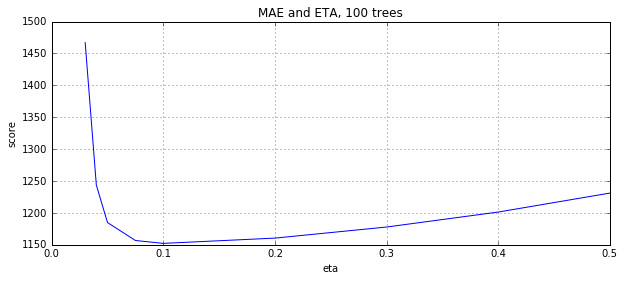

In [34]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

学习率低一些的效果更好

In [35]:
%%time

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: user 21.9 ms, sys: 34 µs, total: 22 ms
Wall time: 22 ms


在增加树的个数呢？

In [36]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1148.37246, std: 6.51203, params: {'eta': 0.09},
  mean: -1146.67343, std: 6.13261, params: {'eta': 0.08},
  mean: -1145.92359, std: 5.68531, params: {'eta': 0.07},
  mean: -1147.44050, std: 6.33336, params: {'eta': 0.06},
  mean: -1147.98062, std: 6.39481, params: {'eta': 0.05},
  mean: -1153.17886, std: 5.74059, params: {'eta': 0.04}],
 {'eta': 0.07},
 -1145.9235944370419)

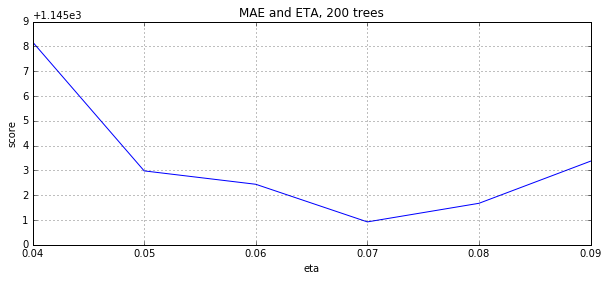

In [37]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [38]:
%%time

# Final XGBoost model


bst = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(train_x, train_y, nfold=5)

CPU times: user 1.26 ms, sys: 22 µs, total: 1.28 ms
Wall time: 1.07 ms


In [39]:
cv

test-mae-mean     1146.997852
test-mae-std         9.541592
train-mae-mean    1036.557251
train-mae-std        0.974437
Name: 199, dtype: float64

我们看到200棵树最好的ETA是0.07。正如我们所预料的那样，ETA和num_boost_round依赖关系不是线性的，但是有些关联。

们花了相当长的一段时间优化xgboost. 从初始值: **1219.57**. 经过调参之后达到 **MAE=1171.77**.

我们还发现参数之间的关系` ETA `和` num_boost_round `：

* 100 trees, `eta=0.1`: **MAE=1152.247**
* 200 trees, `eta=0.07`: **MAE=1145.92**


`XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.07).

